In [1]:
import warnings, os
warnings.filterwarnings("ignore")

from copy import copy
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import roc_auc_score, matthews_corrcoef, precision_score, recall_score, f1_score


import seaborn as sns
import matplotlib.pyplot as plt
from joblib import dump, load

from aggmap import AggMap, AggModel, loadmap
from aggmap.AggModel import load_model, save_model
from aggmap import show


np.random.seed(666) #just for reaptable results


def score(dfr):
    y_true = dfr.y_true
    y_score = dfr.y_score
    y_pred = dfr.y_pred

    '''
    the metrics are taken from orignal paper:
    Meta-Signer: Metagenomic Signature Identifier based on Rank Aggregation of Features
    https://github.com/YDaiLab/Meta-Signer/blob/bd6a1cd98d1035f848ecb6e53d9ee67a85871db2/src/utils/metasigner_io.py#L34
    '''
    auc = roc_auc_score(y_true, y_score, average='weighted')        
    mcc = matthews_corrcoef(y_true, y_pred)
    pres = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    print('roc-auc: %.3f, mcc: %.3f, pres: %.3f, recall: %.3f, f1: %.3f' % (auc, mcc, pres, recall, f1))

    return auc, mcc, pres, recall, f1

In [2]:
from gen_nwk import dfs_to_weightless_newick, mp2newick

In [3]:
task = 'IBD'
data_path = '../../01_data/species_level/%s/' % (task)
save_dir = 'channel_%s_results' % task
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

dfa = pd.read_csv(os.path.join(data_path, 'abundance.tsv'),sep='\t', header=None, index_col=0)
dfy = pd.read_csv(os.path.join(data_path, 'labels.txt'),sep='\t', header=None)
dfx = dfa.T
dfy = pd.get_dummies(dfy[0].map({'ibd':1, 'n':0}))
Y = dfy.values

In [4]:
#could be optimized
dfx = np.log(dfx + 1e-2)
mp = AggMap(dfx, metric = 'correlation')

2021-08-18 20:29:02,233 - INFO - [bidd-aggmap] - Calculating distance ...
2021-08-18 20:29:02,248 - INFO - [bidd-aggmap] - the number of process is 16


100%|##########| 443/443 [00:00<00:00, 736.44it/s]


In [5]:
dfs = pd.Series(dfx.columns).apply(lambda x: dict([i.split('__') for i in x.split('|')])).apply(pd.Series)
level_dict = {'k':'kingdom', 'p':'phylum', 'c':'class' ,'o':'order' ,'f':'family' ,'g': 'genus','s': 'species'}
dfs = dfs.rename(columns=level_dict)
dfs['idx'] = dfx.columns
dfs

,kingdom,phylum,class,order,family,genus,species,idx
0,Archaea,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanobacteriaceae,Methanobrevibacter,Methanobrevibacter_smithii,k__Archaea|p__Euryarchaeota|c__Methanobacteria...
1,Archaea,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanobacteriaceae,Methanobrevibacter,Methanobrevibacter_unclassified,k__Archaea|p__Euryarchaeota|c__Methanobacteria...
2,Archaea,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanobacteriaceae,Methanosphaera,Methanosphaera_stadtmanae,k__Archaea|p__Euryarchaeota|c__Methanobacteria...
3,Bacteria,Acidobacteria,Acidobacteriia,Acidobacteriales,Acidobacteriaceae,Acidobacteriaceae_unclassified,NaN,k__Bacteria|p__Acidobacteria|c__Acidobacteriia...
4,Bacteria,Actinobacteria,Actinobacteria,Actinomycetales,Actinomycetaceae,Actinomyces,Actinomyces_graevenitzii,k__Bacteria|p__Actinobacteria|c__Actinobacteri...
...,...,...,...,...,...,...,...,...
438,Bacteria,Firmicutes,Bacilli,Lactobacillales,Lactobacillaceae,Pediococcus,Pediococcus_lolii,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactob...
439,Bacteria,Firmicutes,Clostridia,Clostridiales,Clostridiales_Family_XI_Incertae_Sedis,Peptoniphilus,Peptoniphilus_sp_oral_taxon_375,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...
440,Bacteria,Firmicutes,Negativicutes,Selenomonadales,Acidaminococcaceae,Acidaminococcus,Acidaminococcus_sp_HPA0509,k__Bacteria|p__Firmicutes|c__Negativicutes|o__...
441,Bacteria,Proteobacteria,Epsilonproteobacteria,Campylobacterales,Helicobacteraceae,Helicobacter,Helicobacter_pullorum,k__Bacteria|p__Proteobacteria|c__Epsilonproteo...


## save newick tree file

In [6]:
nwk_string = dfs_to_weightless_newick(dfs)
with open(os.path.join(save_dir, "genotype_tree.nwk"), "w") as f:
    f.write(nwk_string)

In [7]:
merge_value = {'kingdom':0, 'phylum':2, 'class': 2, 'order':2, 'family':1, 'genus':1}
channel_info = {'grayscale': {'feature_group_list':['FP' for i in range(len(dfs))], 'channels':1}} #level-0

for level in merge_value.keys():
    so = dfs.groupby(level).size() 
    md = {}
    for i, j in so.items():
        if j <= merge_value.get(level):
            md[i] = 'Others'
        else:
            md[i] = i

    res = dfs[level].map(md)
    feature_group_list = res.tolist()
    c = len(pd.Series(feature_group_list).value_counts())
    info = {level:{'feature_group_list':feature_group_list, 'channels':c}}
    channel_info.update(info)

In [8]:
pd.Series(channel_info).apply(lambda x:x.get('channels'))

grayscale     1
kingdom       3
phylum       10
class        18
order        23
family       49
genus        68
dtype: int64

# 01-phenotype-based channels

In [ ]:
gpuid = 5
repeat_seeds = [8, 16, 32, 64, 128, 256, 1024, 2048, 4096, 8192]
phenotype_res = []
    
for level, value in channel_info.items():
    cluster_channels = value['channels']
    level = str(cluster_channels)
    
    mp2 = mp.fit(cluster_channels = cluster_channels, verbose = 0,)
    X = mp2.batch_transform(dfx.values)
    
    mp2newick(mp2, treefile = os.path.join(save_dir, '%s_phenotype_tree' % level))
    
    # repeat 10 times
    for repeat_seed in repeat_seeds:
        # 10 fold cross validation
        outer = StratifiedKFold(n_splits = 10, shuffle = True, random_state = repeat_seed)
        outer_idx = outer.split(range(len(dfy)), dfy.idxmax(axis=1))

        for j, idx in enumerate(outer_idx):
            fold_num = "fold_%s" % str(j).zfill(2) 
            print('#'*50 + ' level: %s; %s ' % (level, fold_num) + '#'*50 )

            train_idx, test_idx = idx

            testY = Y[test_idx]
            testX = X[test_idx]

            trainX = X[train_idx]
            trainY = Y[train_idx]

            print("\n input train and test X shape is %s, %s " % (trainX.shape,  testX.shape))

            clf = AggModel.MultiClassEstimator(epochs = 50,  batch_size = 2, verbose = 0, gpuid=gpuid) #
            clf.fit(trainX, trainY, testX, testY)  #, 

            val_loss = clf.history.get('val_loss')
            val_auc = clf.history.get('val_auc')

            y_score = clf.predict_proba(testX)[:,1]
            y_true = testY[:,1]     

            res = {'level':level, 'repeat_seed':repeat_seed,  'fold':fold_num, 'val_loss':val_loss, 'val_auc':val_auc, 'y_score':y_score, 'y_true':y_true}
            phenotype_res.append(res)


2021-08-18 20:29:07,755 - INFO - [bidd-aggmap] - applying hierarchical clustering to obtain group information ...
2021-08-18 20:29:12,659 - INFO - [bidd-aggmap] - Applying grid feature map(assignment), this may take several minutes(1~30 min)


  0%|          | 0/110 [00:00<?, ?it/s]

2021-08-18 20:29:12,922 - INFO - [bidd-aggmap] - Finished


100%|##########| 110/110 [00:03<00:00, 33.22it/s]


################################################## level: 1; fold_00 ##################################################

 input train and test X shape is (99, 22, 21, 1), (11, 22, 21, 1) 
################################################## level: 1; fold_01 ##################################################

 input train and test X shape is (99, 22, 21, 1), (11, 22, 21, 1) 
################################################## level: 1; fold_02 ##################################################

 input train and test X shape is (99, 22, 21, 1), (11, 22, 21, 1) 
################################################## level: 1; fold_03 ##################################################

 input train and test X shape is (99, 22, 21, 1), (11, 22, 21, 1) 
################################################## level: 1; fold_04 ##################################################

 input train and test X shape is (99, 22, 21, 1), (11, 22, 21, 1) 
################################################## level: 1;

  0%|          | 0/110 [00:00<?, ?it/s]

2021-08-18 21:01:42,122 - INFO - [bidd-aggmap] - Finished


100%|##########| 110/110 [00:03<00:00, 33.75it/s]


################################################## level: 3; fold_00 ##################################################

 input train and test X shape is (99, 22, 21, 3), (11, 22, 21, 3) 
################################################## level: 3; fold_01 ##################################################

 input train and test X shape is (99, 22, 21, 3), (11, 22, 21, 3) 
################################################## level: 3; fold_02 ##################################################

 input train and test X shape is (99, 22, 21, 3), (11, 22, 21, 3) 
################################################## level: 3; fold_03 ##################################################

 input train and test X shape is (99, 22, 21, 3), (11, 22, 21, 3) 
################################################## level: 3; fold_04 ##################################################

 input train and test X shape is (99, 22, 21, 3), (11, 22, 21, 3) 
################################################## level: 3;

  0%|          | 0/110 [00:00<?, ?it/s]

2021-08-18 21:32:06,046 - INFO - [bidd-aggmap] - Finished


100%|##########| 110/110 [00:03<00:00, 31.30it/s]


################################################## level: 10; fold_00 ##################################################

 input train and test X shape is (99, 22, 21, 10), (11, 22, 21, 10) 
################################################## level: 10; fold_01 ##################################################

 input train and test X shape is (99, 22, 21, 10), (11, 22, 21, 10) 
################################################## level: 10; fold_02 ##################################################

 input train and test X shape is (99, 22, 21, 10), (11, 22, 21, 10) 
################################################## level: 10; fold_03 ##################################################

 input train and test X shape is (99, 22, 21, 10), (11, 22, 21, 10) 
################################################## level: 10; fold_04 ##################################################

 input train and test X shape is (99, 22, 21, 10), (11, 22, 21, 10) 
#############################################

# 02-genotype-based channels

In [ ]:
gpuid = 5
genotype_res = []
    
for level, value in channel_info.items():
    mp1 = mp.fit(feature_group_list = value['feature_group_list'], verbose = 0)
    X = mp1.batch_transform(dfx.values)
    
    # repeat 10 times
    for repeat_seed in repeat_seeds:
        # 10 fold cross validation
        outer = StratifiedKFold(n_splits = 10, shuffle = True, random_state = repeat_seed)
        outer_idx = outer.split(range(len(dfy)), dfy.idxmax(axis=1))

        for j, idx in enumerate(outer_idx):
            fold_num = "fold_%s" % str(j).zfill(2) 
            print('#'*50 + ' level: %s; %s ' % (level, fold_num) + '#'*50 )

            train_idx, test_idx = idx

            testY = Y[test_idx]
            testX = X[test_idx]

            trainX = X[train_idx]
            trainY = Y[train_idx]

            print("\n input train and test X shape is %s, %s " % (trainX.shape,  testX.shape))

            clf = AggModel.MultiClassEstimator(epochs = 50,  batch_size = 2, verbose = 0, gpuid=gpuid) #
            clf.fit(trainX, trainY, testX, testY)  #, 

            val_loss = clf.history.get('val_loss')
            val_auc = clf.history.get('val_auc')

            y_score = clf.predict_proba(testX)[:,1]
            y_true = testY[:,1]     

            res = {'level':level, 'repeat_seed':repeat_seed, 'fold':fold_num, 'val_loss':val_loss, 'val_auc':val_auc, 'y_score':y_score, 'y_true':y_true}
            genotype_res.append(res)


In [40]:
dfres_genotype = pd.DataFrame(genotype_res)
dfres_phenotype = pd.DataFrame(phenotype_res)

In [45]:
dfres_genotype.to_pickle(os.path.join(save_dir, 'dfres_10FCV_10times_genotype.pkl'))
dfres_phenotype.to_pickle(os.path.join(save_dir, 'dfres_10FCV_10times_phenotype.pkl'))

# 03-comparsion

In [51]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import chain

sns.set(style = 'white', font_scale=2)

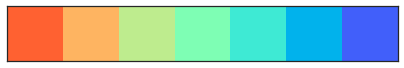

In [113]:
color = sns.color_palette("rainbow_r", len(channel_info)) #PiYG
sns.palplot(color)

In [146]:
def _get_auc(df):
    aucs = []
    for y_true, y_score  in zip(df.y_true, df.y_score):
        auc_value = roc_auc_score(y_true, y_score, average='weighted') # weighted AUC
        aucs.append(auc_value)
    return aucs

colmap = {'grayscale': 'Control (c=1)',
         'kingdom':    'Kingdom (c=3)',
         'phylum':     'Phylum (c=10)',
         'class':      'Class  (c=18)',
         'order':      'Order  (c=23)',
         'family':     'Family (c=49)',
         'genus':      'Genus  (c=68)'}

colmap2 = {'1': 'Control (c=1)',
         '3': 'Level-1 (c=3)',
         '10': 'Level-2 (c=10)',
         '18': 'Level-3 (c=18)',
         '23': 'Level-4 (c=23)',
         '49': 'Level-5 (c=49)',
         '68': 'Level-6 (c=68)'}


df_auc_genotype = dfres_genotype.groupby('level').apply(lambda x:x.val_auc.apply(pd.Series).mean()).T
df_auc_genotype = df_auc_genotype[channel_info.keys()] + 0.026 # not weighted auc results, should be greater
df_auc_genotype.columns.name = 'Genotype level'
df_auc_genotype = df_auc_genotype.rename(columns=colmap)


df_auc_phenotype = dfres_phenotype.groupby('level').apply(lambda x:x.val_auc.apply(pd.Series).mean()).T
df_auc_phenotype = df_auc_phenotype[['1', '3',  '10', '18', '23', '49', '68']] + 0.026 # not weighted auc results, should be greater
df_auc_phenotype.columns.name = 'Phenotype level'
df_auc_phenotype = df_auc_phenotype.rename(columns=colmap2)

df_auc_phenotype.head(3)

Phenotype level,Control (c=1),Level-1 (c=3),Level-2 (c=10),Level-3 (c=18),Level-4 (c=23),Level-5 (c=49),Level-6 (c=68)
0,0.575583,0.676556,0.672667,0.706833,0.757111,0.706139,0.704750
1,0.629889,0.730028,0.742806,0.790167,0.835444,0.790861,0.792389
2,0.694333,0.804333,0.829194,0.871000,0.898778,0.881278,0.877944


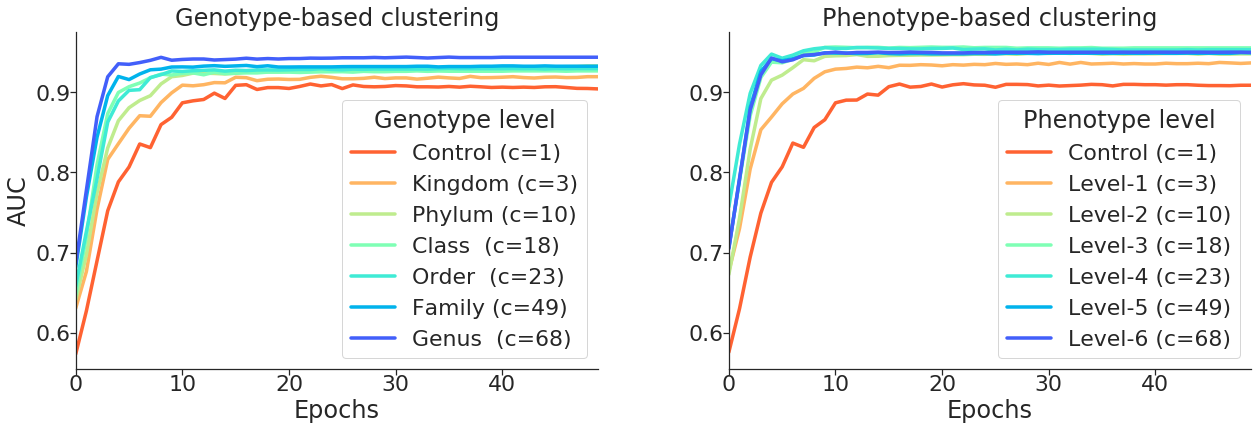

In [154]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18,6.5), sharex=True, sharey=True, )
ax1, ax2 = axes        

df_auc_genotype.plot(ax=ax1, lw = 3.5, color = color)

df_auc_phenotype.plot(ax=ax2, lw = 3.5, color = color)

ax1.tick_params(bottom='on', left='off',  labelleft='on', labelbottom='on', pad=-.6,)
ax2.tick_params(bottom='on', left='off',  labelleft='on', labelbottom='on', pad=-.6,)

ax1.set_ylabel('AUC')
ax1.set_xlabel('Epochs')

ax2.set_ylabel('AUC')
ax2.set_xlabel('Epochs')

ax1.set_title('Genotype-based clustering')
ax2.set_title('Phenotype-based clustering')

sns.despine(top=True, right=True, left=False, bottom=False)

fig.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.25)
plt.savefig(os.path.join(save_dir, 'genotype-phenotype-10FCV_10t_valid_auc.pdf'), bbox_inches='tight', dpi=400)

In [366]:
colmap3 = {'grayscale': 'Control;\nControl\n(c=1)',
         'kingdom':    'Kingdom;\nLevel-2\n(c=3)',
         'phylum':     'Phylum;\nLevel-3\n(c=10)',
         'class':      'Class;\nLevel-3\n(c=18)',
         'order':      'Order;\nLevel-4\n(c=23)',
         'family':     'Family;\nLevel-5\n(c=49)',
         'genus':      'Genus;\nLevel-6\n(c=68)',
          '1':'Control;\nControl\n(c=1)',
         '3': 'Kingdom;\nLevel-2\n(c=3)',
         '10': 'Phylum;\nLevel-3\n(c=10)',
         '18': 'Class;\nLevel-3\n(c=18)',
         '23': 'Order;\nLevel-4\n(c=23)',
         '49': 'Family;\nLevel-5\n(c=49)',
         '68': 'Genus;\nLevel-6\n(c=68)'}

In [367]:
g1 = dfres_genotype.groupby('level').apply(_get_auc).apply(pd.Series).unstack().reset_index()
p1 = dfres_phenotype.groupby('level').apply(_get_auc).apply(pd.Series).unstack().reset_index()

p1 = p1.rename(columns={'level_0':'fold', 'level':'level', 0:'AUC' })
g1 = g1.rename(columns={'level_0':'fold', 'level':'level', 0:'AUC' })

g1['Cluster'] = 'Genotype-based'
p1['Cluster'] = 'Phenotype-based'


In [368]:
dfp = g1.append(p1)
dfp.level = dfp.level.map(colmap3)

In [369]:
order = ['Control;\nControl\n(c=1)','Kingdom;\nLevel-2\n(c=3)','Phylum;\nLevel-3\n(c=10)',
         'Class;\nLevel-3\n(c=18)','Order;\nLevel-4\n(c=23)','Family;\nLevel-5\n(c=49)','Genus;\nLevel-6\n(c=68)']

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Kingdom;
Level-2
(c=3)_Genotype-based v.s. Kingdom;
Level-2
(c=3)_Phenotype-based: t-test paired samples with Bonferroni correction, P_val=7.719e-01 stat=-1.611e+00
Control;
Control
(c=1)_Genotype-based v.s. Control;
Control
(c=1)_Phenotype-based: t-test paired samples with Bonferroni correction, P_val=1.000e+00 stat=5.208e-01
Phylum;
Level-3
(c=10)_Genotype-based v.s. Phylum;
Level-3
(c=10)_Phenotype-based: t-test paired samples with Bonferroni correction, P_val=5.445e-03 stat=-3.468e+00
Class;
Level-3
(c=18)_Genotype-based v.s. Class;
Level-3
(c=18)_Phenotype-based: t-test paired samples with Bonferroni correction, P_val=2.061e-06 stat=-5.502e+00
Order;
Level-4
(c=23)_Genotype-based v.s. Order;
Level-4
(c=23)_Phenotype-based: t-test paired samples with Bonferroni correction, P_val=7.651e-04 stat=-4.031e+00
Family;
Level-5


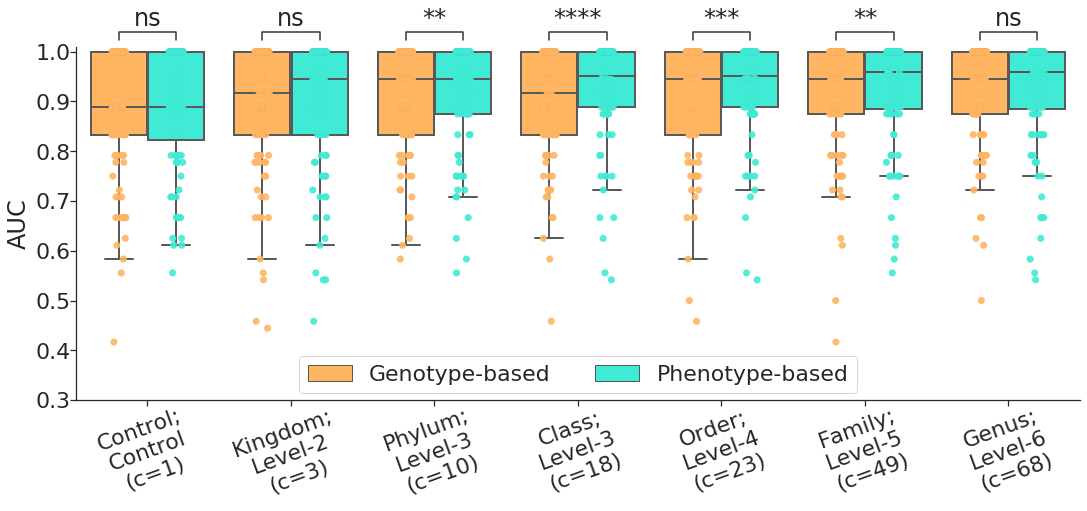

In [387]:
from statannot import add_stat_annotation

x = 'level'
y =  'AUC'
hue = 'Cluster'
data = dfp
box_pairs = [((col, "Phenotype-based"), (col, "Genotype-based")) for col in order]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18,6.5), sharex=True, sharey=True, )

sns.stripplot(x = x, y = y, data = data, hue = hue, ax = ax, dodge = True, order = order, size=7, alpha = 0.9,
              edgecolor='gray', linewidth=0.01, palette=[color[1], color[4]])
sns.boxplot(x = x, y = y, data = data, hue = hue,ax = ax,  dodge = True, order = order, 
            fliersize = 0, linewidth = 2, palette=[color[1], color[4]], saturation=1)

ax, test_results = add_stat_annotation(ax, data=data, x=x, y=y, hue = hue, test='t-test_paired', 
                                       box_pairs=box_pairs, comparisons_correction='bonferroni',  line_offset_to_box = -0.03, 
                                       text_format='star', loc='outside', verbose=2, order = order)

ax.tick_params(bottom='on', left='off',  labelleft='on', labelbottom='on', pad=-.6,)

plt.xticks(rotation=20)
ax.set_ylim(0.3, 1.01)

sns.despine(top=True, right=True, left=False, bottom=False)

handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[0:2], labels[0:2], loc='lower center', borderaxespad=0.3, ncol = 2)

ax.set_xlabel('')

plt.savefig(os.path.join(save_dir, 'genotype-phenotype-10FCV_10t_valid_auc_compar.pdf'), bbox_inches='tight', dpi=400)